# scgpgmm GMMGP
This actually works currently
https://pyro.ai/examples/scgpgmm.html
https://docs.scvi-tools.org/en/stable/user_guide/models/scgpgmm.html

In [1]:
# various import statements
import numpy as np

import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
from torch.optim import Adam
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
import pyro.contrib
import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
foo='hello'
bar='world'
import os
import sklearn
from sklearn import cluster
import pandas as pd
import re
import scanpy as sc
print(f"{foo=} {bar=}")
from torch import exp
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))
sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')
    

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


foo='hello' bar='world'


In [2]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *

import importlib
model_functions=importlib.reload(model_functions)
from model_functions import *

In [3]:
smoke_test=False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device="cpu"


cuda:0


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/scratch/fast/13727558/ipykernel_103347/819467349.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  species_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['species'].cat.codes).long(),num_classes=len(adata.obs['species'].cat.categories)).float()
/scratch/fast/13727558/ipykernel_103347/819467349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

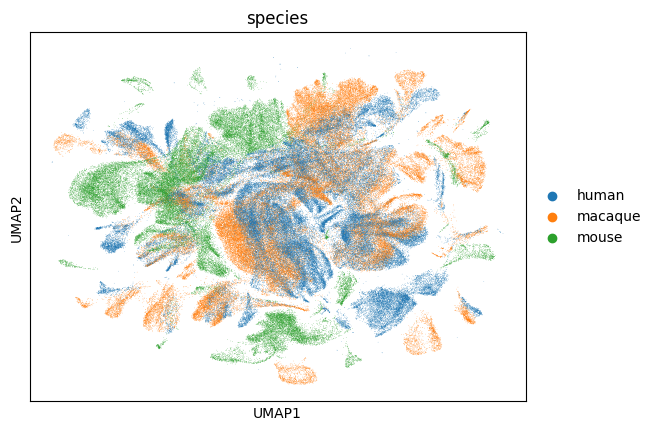

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

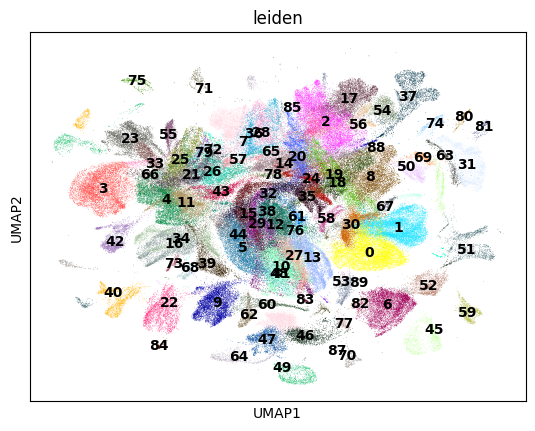

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

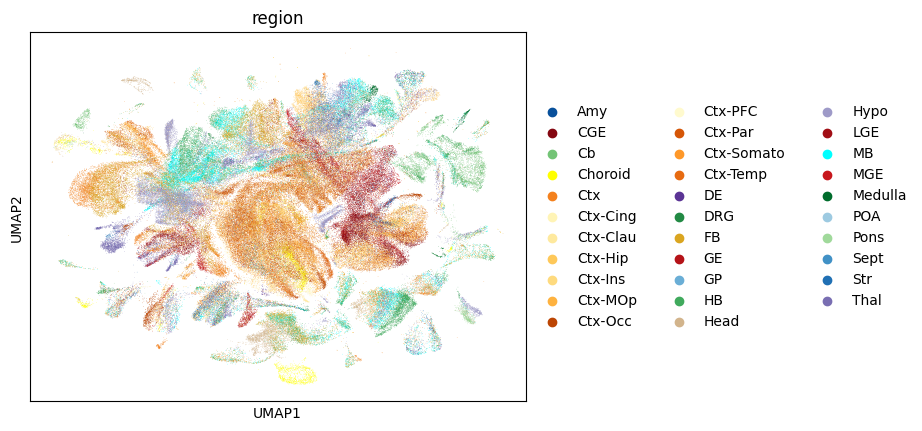

In [4]:
#adata=sc.read(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_900k_RPCA_clusters.h5ad'))
adata=sc.read(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part1.h5ad'))

species_arg=adata.obs['species'].cat.codes
species_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['species'].cat.codes).long(),num_classes=len(adata.obs['species'].cat.categories)).float()

adata.uns['batch_cats']=dict(zip([str(x) for x in adata.obs['batch_name'].cat.categories],[str(x) for x in sorted(set(adata.obs['batch_name'].cat.codes))]))
batch_arg=adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)
batch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)).long(),
                                         num_classes=len(adata.uns['batch_cats'].keys())).float()


adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]#.todense()
#adata=adata[np.random.choice(adata.obs.index,100000,replace=False),:]
#sc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",subset=True)

adata=adata[~adata.obs.general_region.isin(['Cultured']),:]
adata=adata[~adata.obs.batch_name.str.contains('P10'),:]
#adata=adata[adata.obs['general_region'].isin(['bn','cp','ctx','ge']),:]

adata.obs['species']=adata.obs['species'].astype('category')
sc.pl.umap(adata,color=['species'])
sc.pl.umap(adata,color=['leiden'],legend_loc="on data")
sc.pl.umap(adata,color='region')
adata.obsm['X_original_umap']=adata.obsm['X_umap']
adata.obs['n_counts']=adata.X.sum(1)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

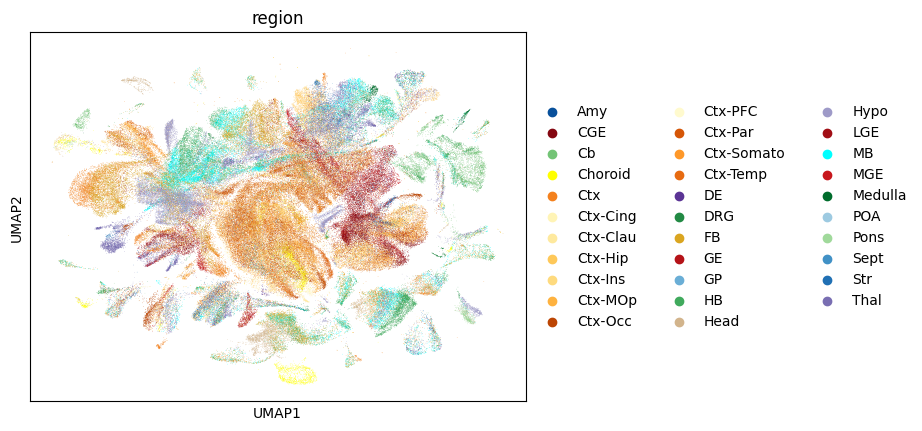

In [5]:
sc.pl.umap(adata,color='region')

In [6]:
#adata.obs['batch_name']=adata.obs['batch_name'].astype(str)
#adata.obs['batch_name']=adata.obs['batch_name'].astype('category')
#adata.uns['batch_cats']=dict(zip([str(x) for x in adata.obs['batch_name'].cat.categories],[str(x) for x in sorted(set(adata.obs['batch_name'].cat.codes))]))

In [7]:
samplegroups={'FB':'vt',
'bn':'vt',
'ctx':'ctx',
'cp':'vt',
'de':'de',
'ge':'vt',
'h':'vt',
'hb':'hb',
'mb':'mb'}
adata.obs['sample_region']=adata.obs['general_region'].replace(samplegroups)
adata.obs['region_species']=adata.obs['sample_region'].astype(str)+'_'+adata.obs['species'].astype(str)


In [8]:
#sc.pl.umap(adata,color='sample_region')

<Axes: xlabel='general_region'>

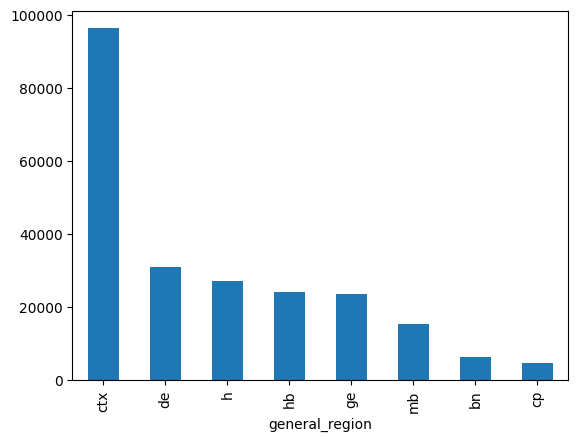

In [9]:
adata.obs['general_region'].value_counts().plot.bar()

<Axes: xlabel='sample_region'>

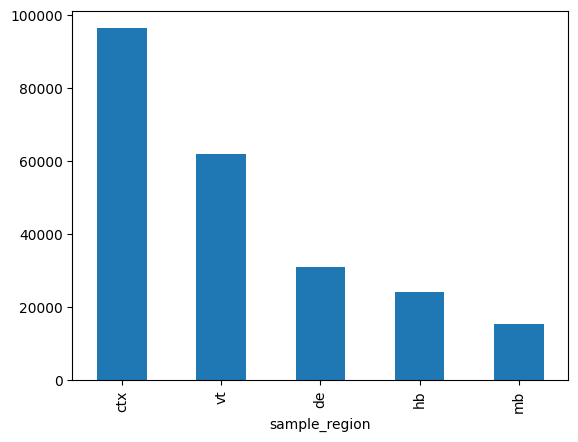

In [10]:
adata.obs['sample_region'].value_counts().plot.bar()

/scratch/fast/13727558/ipykernel_103347/3470349541.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('species')['sample_region'].value_counts(normalize=True).unstack().T.plot.bar()


<Axes: xlabel='sample_region'>

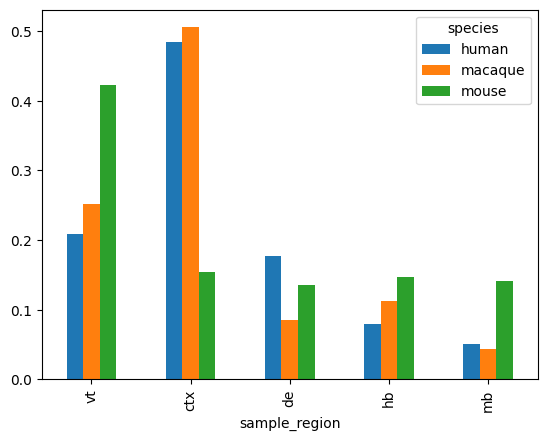

In [11]:
adata.obs.groupby('species')['sample_region'].value_counts(normalize=True).unstack().T.plot.bar()

In [12]:
batch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['batch_name'].cat.codes).long(),num_classes=len(adata.obs['batch_name'].cat.categories)).float()
adata.obs['batch_name']

/scratch/fast/13727558/ipykernel_103347/2805410280.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['batch_name'].cat.codes).long(),num_classes=len(adata.obs['batch_name'].cat.categories)).float()


GTCTCGTCAGCATACT_PEC_Yale_SingleCellRNAseq_RMB683_CBC    PEC_Yale_SingleCellRNAseq_RMB683_CBC
CTTTCGGAGGCGTCCT_GW19_CGE_v3_0_1_HM732DMXX_kOut                GW19_CGE_v3_0_1_HM732DMXX_kOut
TAACCAGGTGGGAGAG_E65-2019A_PFC                                                  E65-2019A_PFC
TACGTACACTAAGT_SRR6061125_E13.5_CGE                                      SRR6061125_E13.5_CGE
TTTAGGCTACCTTT_e10.0_Forebrain_SRR11947624                        e10.0_Forebrain_SRR11947624
                                                                         ...                 
TCGCAGGAGTAGTCTC_E80-2022_Diencephalon_2                              E80-2022_Diencephalon_2
TTGTAGGAGTGTTAGA_E50_PFC                                                              E50_PFC
GATCAGTGTTACAGAA_E100hippo                                                          E100hippo
TGCACGGTCCCGTGAG_GW16_V1VZ_0_1_HNJJMDMXX_kOut                    GW16_V1VZ_0_1_HNJJMDMXX_kOut
CCACCTACACATTCGA_GW20cingulate-corpus_kOut                  

# Put everything together

In [13]:
# Packages the scgpgmm model and guide as a PyTorch nn.Module

class SCGPGMM(nn.Module):
    """
    SCGPGMM is a variational inference model that is developed for the analysis and 
    categorization of cell types across evolution based on single-cell data. 

    Parameters:
    num_var (int): Number of variables (features) in the dataset.
    l_loc (float): The location parameter for the length scale of the Gaussian Process.
    l_scale (float): The scale parameter for the length scale of the Gaussian Process.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 20, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 10.
    alpha (float, optional): The Dirichlet concentration parameter. Defaults to 0.01.
    scale_factor (float, optional): Scaling factor for data normalization. Defaults to 1.0.
    num_species (int, optional): Number of species (or groups) in the dataset. Defaults to 1.
    num_batch (int, optional): Number of batches to correct for in the data. Defaults to 1.
    prior_scale (float, optional): Scale of the laplace prior distributions. Defaults to 100.
    tree_approx (bool, optional): Flag to indicate whether to use a tree approximation. Defaults to False.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.

    """
    def __init__(self, num_var, l_loc, l_scale,level_sizes=[1,10,20,50],
                 num_latent=10, alpha=0.01, scale_factor=1.0,
                 num_species=1,num_batch=1,prior_scale=100,
                 tree_approx=False,bi_depth=2):
        
        self.pi=3.14159265
        self.num_var = num_var
        self.num_species = num_species
        self.num_batch = num_batch
        self.num_latent = num_latent
        self.scale_factor=scale_factor
        self.level_sizes=level_sizes
        self.num_labels = np.sum(self.level_sizes)
        self.level_indices=np.cumsum([0]+self.level_sizes)
        #how deep in the tree should batch by identity be accounted for
        self.bi_depth=bi_depth

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.l_loc = l_loc
        self.l_scale = l_scale

        self.dm=DM(self)
        self.bm=BM(self)
        self.di=DI(self)
        self.bint=BInt(self)
        self.bif=BIFull(self)
        self.ci=CI(self)
        self.zdw=ZDW(self)
        self.dc=DC(self)
        self.bc=BC(self)
        self.zs=ZScale(self)
        self.tree_edges=TreeEdges(self,straight_through=False)
        self.tree_convergence=TreeConvergence(self)        
        self.z_transform=centered_sigmoid#torch.special.expit#null_function
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=num_var,hidden_dims=[6000,3000,1000],num_cat_input=self.num_species,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus),(1,None),(1,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,
                    outputs=[(self.num_labels,safe_sigmoid),(1,None),(1,softplus)])

        #self.bc_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[200,200,50,5],
        #            out_dim=self.num_var*self.num_latent)
        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.bi_nn=SimpleFFNN(in_dim=self.num_batch+sum(level_sizes[:self.bi_depth]),hidden_dims=[1000,1000,2000,3000],
                    out_dim=self.num_var)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=True
        self.hard=False
        #Whether to approximate tree connectivity during approximation mode
        self.tree_approx=tree_approx#Not sure if this is necessary

        self.prior_scale=prior_scale

        
    def set_approx(self,b: bool):
        self.approx=b
        
    def set_hard(self,b: bool):
        self.hard=b

    def model(self, s=None,species=None,batch=None,y1=None,exploded=False):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("scgpgmm", self)
        if batch is None:
            batch=s.new_zeros((s.shape[0],self.num_batch))
        if species is None:
            species=s.new_zeros((s.shape[0],self.num_species))
        species_ind=species.argmax(1)
        batch_ind=batch.argmax(1)

        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            intron_scale = pyro.param("intron_scale_factor", s.new_ones(self.num_species,self.num_var),
                       constraint=constraints.positive)
            s_theta = pyro.param("s_inverse_dispersion", 25.0 * s.new_ones(self.num_var),
                               constraint=constraints.positive)

            locs=pyro.param("locs", 0.1*torch.randn((self.num_labels,self.num_latent)).to(s.device))
            #locs=pyro.param("locs", torch.zeros((self.num_labels,self.num_latent)).to(s.device))
            #scales=self.zs.model_sample(s)
            scales=self.zs.make_params(s)
            locs_dynam=pyro.param("locs_dynam", torch.zeros((self.num_labels,self.num_latent)).to(s.device))
            
            species_dm=self.dm.model_sample(s)
            species_di=self.di.model_sample(s)
            batch_dm=self.bm.model_sample(s)
            cluster_intercept=self.ci.model_sample(s)
            #z_decoder_weight=self.zdw.model_sample(s)
            z_decoder_weight=self.zdw.make_params(s)
            level_edges=self.tree_edges.model_sample(s,approx=self.approx&self.tree_approx)
            species_dc=self.dc.model_sample(s)
            
            l_mu = pyro.param("l_mu", self.l_loc * s.new_ones(self.num_batch,1))
            l_scale = pyro.param("l_scale",  self.l_scale * s.new_ones(self.num_batch,1),
                               constraint=constraints.positive) 
            scd=pyro.param("species_constitutive_de", s.new_zeros((self.num_species,self.num_var)))
            
            
            # We scale all sample statements by scale_factor so that the ELBO loss function
            # is normalized wrt the number of datapoints and genes.
            # This helps with numerical stability during optimization.
            with pyro.plate("batch", s.shape[0]):
                l = pyro.sample("l", dist.LogNormal(l_mu[batch_ind], l_scale[batch_ind]).to_event(1))
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10.

                if self.approx:
                    y1 = pyro.sample("y1", dist.Beta(beta_prior_a,1.*s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    l = pyro.sample("l_obs", dist.LogNormal(l.log(), s.new_ones(s.shape[0],1)).to_event(1),obs=s.sum(1).unsqueeze(-1))
                else:
                    y1 = pyro.sample("y1", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    y1 = pyro.sample('y1_ber',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=y1).to_event(1))
                    l = pyro.sample("l_obs", dist.LogNormal(l.log(), s.new_ones(s.shape[0],1)).to_event(1),obs=s.sum(1).unsqueeze(-1))

                self.tree_convergence.model_sample(y1,level_edges,s)
                #bc=self.bc.model_sample(s)
                bi=self.bif.model_sample(s)
                #psi = pyro.sample('psi',dist.Normal(s.new_zeros(s.shape[0],1),1*s.new_ones(s.shape[0],1)).to_event(1))
                this_locs=oh_index(locs,y1)#+(oh_index(locs_dynam,y1)*psi)
                this_scales=oh_index(scales,y1)
                if self.hard:
                    z_loc=pyro.sample('z_loc', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))
                z=z+oh_index2(species_dm[species_ind],y1) + oh_index2(batch_dm[batch_ind],y1)
                z=self.z_transform(z)
                cur_species_di=oh_index2(species_di[species_ind],y1)
                cur_cluster_intercept=oh_index(cluster_intercept,y1)
                mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+species_dc[species_ind])#+bc
                spliced_mu=mu+scd[species_ind]+cur_species_di+cur_cluster_intercept+bi
                spliced_out=torch.softmax(spliced_mu,dim=-1)                
                log_mu = (l * spliced_out + 1e-6).log()
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist.to_event(1), obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s, species=None,batch=None,y1=None,exploded=False):
        pyro.module("scgpgmm", self)
        if batch is None:
            batch=s.new_zeros((s.shape[0],self.num_batch))
        if species is None:
            species=s.new_zeros((s.shape[0],self.num_species))
        species_ind=species.argmax(1)
        batch_ind=batch.argmax(1)
        with poutine.scale(scale=self.scale_factor):
            locs=pyro.param("locs", 0.1*torch.randn((self.num_labels,self.num_latent)).to(s.device))
            #scales=self.zs.guide_sample(s)
            scales=self.zs.make_params(s)          
            #z_decoder_weight=self.zdw.guide_sample(s)
            #Scale by vector of y to answer long standing sampling problem :)
            species_dm=self.dm.guide_sample(s)
            batch_dm=self.bm.guide_sample(s)
            species_di=self.di.guide_sample(s)
            cluster_intercept=self.ci.guide_sample(s)
            species_dc=self.dc.guide_sample(s)
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx&self.tree_approx) 
            
            with pyro.plate("batch", s.shape[0]):
                z_loc, z_scale,l_loc, l_scale= self.zl_encoder(s,species)
                l=pyro.sample("l", dist.LogNormal(l_loc, l_scale+self.epsilon).to_event(1))
                if self.hard:
                    z=pyro.sample('z_loc',dist.Delta(z_loc).to_event(1))
                else:
                    z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                z=self.z_transform(z)
                y1_probs,psi_loc,psi_scale=self.classifier(z)
                #y1_probs=(y1_probs+1e-6)*(1-1e-5)
                y1_dist = dist.Delta(y1_probs,validate_args=True).to_event(1)
                y1 = pyro.sample("y1", y1_dist)
                if not self.approx:
                    y1 = pyro.sample('y1_ber',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=y1).to_event(1))
                if self.hard:
                    this_locs=oh_index(locs,y1)
                    this_scales=oh_index(scales,y1)
                    z=pyro.sample('z',dist.Normal(this_locs,this_scales+self.epsilon).to_event(1))
                
                self.tree_convergence.guide_sample(y1,level_edges,s)
                #self.bc.guide_sample(self.bc_nn,batch,s)
                #self.bif.guide_sample(self.bi_nn,batch,torch.round(y1[...,:sum(self.level_sizes[:self.bi_depth])]))#Kill y1 gradient path
                self.bif.guide_sample(self.bi_nn,batch,y1[...,:sum(self.level_sizes[:self.bi_depth])])#Kill y1 gradient path?
                
            if exploded:   
                print('EXPLODED')
                print('scales',minmax(scales))
                print('z_decoder_weight',minmax(z_decoder_weight))
                print('species_dm',minmax(species_dm))
                print('species_di',minmax(species_di))
                print('batch_intercept',minmax(batch_intercept))
                print('cluster_intercept',minmax(cluster_intercept))
                print('z',minmax(z))
                print('z_decoder_weight',minmax(z_decoder_weight))
                print('this_locs',minmax(this_locs))
                print('this_scales',minmax(this_scales))
                print('y1',minmax(y1))
                print('y1_probs',minmax(y1_probs))


In [14]:
try:
    del scgpgmm
    torch.cuda.empty_cache()
except:
    pass

In [15]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *

import importlib
model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *


In [16]:
device='cuda'
num_var=adata.shape[1]
l_mean=np.log(adata.X.sum(1)).mean()
l_scale=np.log(adata.X.sum(1)).std()
batch_size=32
level_sizes=[1,25,75,225]
num_latent=200
num_labels=sum(level_sizes)


# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(True)

# Instantiate instance of model/guide and various neural networks
scgpgmm = SCGPGMM(num_var=num_var, num_latent=num_latent,level_sizes=level_sizes,
                l_loc=l_mean, l_scale=l_scale,num_species=len(adata.obs['species'].unique()),
                num_batch=len(adata.obs['batch_name'].unique()),
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,tree_approx=True,prior_scale=100.)


# Setup an optimizer (Adam) and learning rate scheduler.
# We start with a moderately high learning rate (0.006) and
# reduce by a factor of 5 after 20 epochs.
scheduler =pyro.optim.ClippedAdam({'lr':0.001,'lrd':(1-(6e-6))})


# Setup a variational objective for gradient-based learning.
# Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
# for automatic enumeration of the discrete latent variable y.
elbo = pyro.infer.JitTrace_ELBO(num_particles=5,strict_enumeration_warning=False)

svi = SVI(scgpgmm.model, scgpgmm.guide, scheduler, elbo)

In [ ]:
device='cuda'
scgpgmm.train()
scgpgmm.zl_encoder.train()
num_epochs=2

grad_check=False
from collections import defaultdict
param_d=defaultdict(list)

adata_toppath=os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM')
adata_paths=os.listdir(adata_toppath)
adata_paths=sorted([os.path.join(adata_toppath,x) for x in adata_paths if 'HvQvMall_part' in x])

scgpgmm=scgpgmm.to(device)
scgpgmm.set_approx(True)
loss_tracker=[]
for epoch in range(num_epochs):
    losses=[]
    count=0
    for adata_path in reversed(adata_paths[1:]):
        print(adata_path)
        dataloader=make_dataloader(origdata=adata,adata_path=os.path.expanduser(adata_path),batch_size=batch_size)
        for x in tqdm.tqdm(dataloader):
            args=[y.to(device) for y in x]
            loss=svi.step(*args)
            losses.append(loss)
            count+=1
            loss_tracker.append(loss)
            if ((count%1000 == 0) | (count%1000 == 1))& grad_check:
                for p in pyro.get_param_store():
                    param_d[p].append(pyro.param(p).clone().detach().cpu())
        # Tell the scheduler we've done one epoch.
        print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))
        
allDone()
print("Finished training!")

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part9.h5ad


 71%|███████   | 5075/7156 [09:21<03:26, 10.07it/s]

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
if grad_check:
    param_delta=dict()
    for p in param_d.keys():
        param_delta[p]=[param_d[p][i]-param_d[p][i+1] for i in range(0,len(param_d[p])-1,2)]

    meandelta=dict()
    for p in param_delta.keys():
        meandelta[p]=np.array([x.abs().mean().numpy() for x in param_delta[p]])

    for p in meandelta.keys():
        if '' in p:#edges
            ax=seaborn.lineplot(x=list(range(len(meandelta[p]))),y=meandelta[p],label=p,)
            seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
            ax
        #plt.show()

In [ ]:
"""
scgpgmm.dc_batch_encoder.cpu()
seaborn.histplot(scgpgmm.dc_batch_encoder(torch.eye(batch_values.shape[1])).detach().cpu().numpy().flatten()[:10000],bins=100)
plt.show()
scgpgmm.dc_batch_encoder.to(device)
"""

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),bins=50)

In [ ]:
seaborn.clustermap(scgpgmm.z_transform(pyro.param('locs')).cpu().detach().numpy(),cmap='coolwarm')

In [ ]:
seaborn.clustermap(pyro.param('scales').cpu().detach().numpy())

In [ ]:
seaborn.histplot(pyro.param('s_inverse_dispersion').detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').var(1).detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.heatmap(pyro.param('edges_1').cpu().detach().numpy())
plt.show()
seaborn.heatmap(pyro.param('edges_2').cpu().detach().numpy())
plt.show()

In [ ]:
seaborn.heatmap(torch.softmax(pyro.param('edges_1'),dim=-1).cpu().detach().numpy())
plt.show()
seaborn.heatmap(torch.softmax(pyro.param('edges_2'),dim=-1).cpu().detach().numpy())
plt.show()

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),color='yellow',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[0].cpu().detach().numpy().flatten(),color='red',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[1].cpu().detach().numpy().flatten(),color='blue',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[2].cpu().detach().numpy().flatten(),color='green',bins=50,stat='percent')

In [ ]:
print(pyro.param('z_decoder_weight').var())
print(pyro.param('species_dc').flatten(1,2).var(1))

In [ ]:
seaborn.histplot(pyro.param('locs').cpu().detach().numpy().flatten(),color="green",label='ancestral',bins=50)
seaborn.histplot(pyro.param('species_dm')[0,:,:].cpu().detach().numpy().flatten(),color="red",bins=50)
seaborn.histplot(pyro.param('species_dm')[1,:,:].cpu().detach().numpy().flatten(),color="pink",bins=50)
seaborn.histplot(pyro.param('species_dm')[2,:,:].cpu().detach().numpy().flatten(),color="purple",bins=50)
plt.legend()

In [ ]:
seaborn.clustermap(pyro.param('locs_dynam').cpu().detach().numpy())

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),bins=50)

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').var(1).detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.histplot(pyro.param('cluster_intercept').cpu().detach().numpy().flatten(),color='yellow',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[0].cpu().detach().numpy().flatten(),color='red',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[1].cpu().detach().numpy().flatten(),color='blue',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[2].cpu().detach().numpy().flatten(),color='green',bins=50,stat='percent')


In [ ]:
device='cpu'
scgpgmm=scgpgmm.to(device)
avgpool=nn.AvgPool1d(2,stride=1)
# Now that we're done training we'll inspect the latent representations we've learned
import scanpy as sc
adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
# Put the neural networks in evaluation mode (needed because of batch norm)
scgpgmm.eval()
scgpgmm.zl_encoder.eval()

# Compute latent representation (z_loc) for each cell in the dataset
inputs=[torch.tensor(adata.layers['spliced'].todense()).to(device),species_values]
function=scgpgmm.zl_encoder
num_outs=4
encoded=batch_torch_outputs(inputs,function,batch_size=2048,device='cuda')

clusternames=[]
for i in range(scgpgmm.num_latent):
    clusternames.append(str(i))

adata.obs['LDA0max']=np.array(clusternames)[encoded[0].cpu().detach().numpy().argmax(1)]

sc.pl.umap(adata,color=['LDA0max'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(adata,color=['LDA0max'],palette=sc.pl.palettes.godsnot_102)
"""
for i in range(num_latent):
    adata.obs['test'+str(i)]=torch.softmax(encoded[0],dim=-1)[:,i].cpu().detach().numpy()
sc.pl.umap(adata,color=['test'+str(x) for x in range(num_latent)],use_raw=False,cmap='Purples')
"""
seaborn.clustermap(np.corrcoef((scgpgmm.z_transform(encoded[0])).T.cpu().detach().numpy()))


In [ ]:
"""device='cpu'
inputs=[torch.cat([torch.tensor(adata.layers['spliced'].todense()).to(device),species_values],dim=-1)]
function=scgpgmm.l_encoder
num_outs=1
encoded_vals=batch_torch_outputs(inputs,function,num_outs,batch_size=2048,device='cpu')
encoded=[]
encoded.append(encoded_vals[0][:,:1])
encoded.append(encoded_vals[0][:,1:])
seaborn.scatterplot(pyro.param('l_mu').detach().cpu().flatten()[batch_values.argmax(1)],encoded[0].detach().cpu().flatten(),alpha=0.1)
"""

In [ ]:
seaborn.scatterplot(x=pyro.param('l_mu').detach().cpu().flatten(),y=pyro.param('l_scale').detach().cpu().flatten())

In [ ]:
seaborn.scatterplot(x=pyro.param('l_mu').detach().cpu().flatten()[batch_values.argmax(1)],y=encoded[2].detach().cpu().flatten(),alpha=0.1)

In [ ]:
seaborn.scatterplot(x=pyro.param('l_scale').detach().cpu().flatten()[batch_values.argmax(1)],y=encoded[3].detach().cpu().flatten())

In [ ]:
seaborn.scatterplot(x=encoded[2].detach().cpu().flatten(),y=np.log(adata.obs['n_counts']))

In [ ]:
classouts=batch_torch_outputs([(scgpgmm.z_transform(encoded[0]))],scgpgmm.classifier,batch_size=2048,device='cuda')
o2=classouts[0]

In [ ]:
y1=classouts[0].detach().cpu().numpy()
levels=[y1[...,scgpgmm.level_indices[i]:scgpgmm.level_indices[i+1]] for i in range(len(scgpgmm.level_sizes))]
for i in range(len(levels)):
    adata.obs['level_'+str(i)]=levels[i].argmax(1)
    adata.obs['level_'+str(i)]=adata.obs['level_'+str(i)].astype(str)

adata.obs['scgpgmm_cluster']=adata.obs['level_1']+'_'+adata.obs['level_2']+'_'+adata.obs['level_3']

In [ ]:
y1=classouts[0].detach().cpu().numpy()

levels = [y1[..., scgpgmm.level_indices[i]:scgpgmm.level_indices[i + 1]]
          for i in range(len(scgpgmm.level_sizes))]


for i, level in enumerate(levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the levels to form the cluster label
adata.obs['scgpgmm_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(levels))]), axis=1)

In [ ]:
levels=[y1[...,scgpgmm.level_indices[i]:scgpgmm.level_indices[i+1]] for i in range(len(scgpgmm.level_sizes))]

level_edges=[safe_softmax(pyro.param('edges_'+str(i))).detach().cpu().numpy() for i in range(len(scgpgmm.level_sizes)-1)]

#But still need to propagate edges to get the root value (check for cycles)
results=[levels[-1]]
for i in range(len(scgpgmm.level_sizes) - 2, -1, -1):
    result=levels[i+1]@level_edges[i]
    results.append(result)
results=results[::-1]

for i in range(len(results)):
    adata.obs['prop_level_'+str(i)]=results[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['prop_level_'+str(i)].astype(str)

adata.obs['prop_scgpgmm_cluster']=adata.obs['prop_level_1']+'_'+adata.obs['prop_level_2']+'_'+adata.obs['prop_level_3']

In [ ]:
vcs=adata.obs['scgpgmm_cluster'].value_counts()
legit_clusters=vcs.index[vcs>100]
adata.obs.loc[~adata.obs['scgpgmm_cluster'].isin(legit_clusters),'scgpgmm_cluster']='nan'

vcs=adata.obs['prop_scgpgmm_cluster'].value_counts()
legit_clusters=vcs.index[vcs>100]
adata.obs.loc[~adata.obs['prop_scgpgmm_cluster'].isin(legit_clusters),'prop_scgpgmm_cluster']='nan'

In [ ]:
sc.pl.umap(adata,color=['level_1','level_2','level_3','scgpgmm_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(adata,color=['prop_level_1','prop_level_2','prop_level_3','scgpgmm_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:
seaborn.clustermap(o2[:10000,:],row_cluster=False)

In [ ]:
seaborn.histplot(np.log10(o2.sum(0).cpu().detach().numpy()+1))

In [ ]:
seaborn.clustermap(o2[:1000,:]>0.5)

In [ ]:
adata.obsm['X_scgpgmm']=(scgpgmm.z_transform(encoded[0])).detach().data.cpu().numpy()
random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_scgpgmm")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(xdata,color=['level_1','level_2','level_3','scgpgmm_cluster'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(xdata,color=['scgpgmm_cluster','prop_scgpgmm_cluster'],use_raw=False,palette=sc.pl.palettes.godsnot_102)

In [ ]:
xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)

In [ ]:
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')

In [ ]:
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)


In [ ]:
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


In [ ]:
scheduler=pyro.optim.ClippedAdam({'lr':0.0005,'lrd':(1-(5e-7))})
elbo=pyro.infer.JitTrace_ELBO(num_particles=3,strict_enumeration_warning=False)
svi=SVI(scgpgmm.model, scgpgmm.guide, scheduler, elbo)

device='cuda'
scgpgmm.train()
scgpgmm.zl_encoder.train()
scgpgmm=scgpgmm.to(device)
scgpgmm.set_approx(False)
num_epochs=2

grad_check=False
param_d=defaultdict(list)

loss_tracker=[]
for epoch in range(num_epochs):
    losses=[]
    # Take a gradient step for each mini-batch in the dataset
    count=0
    for adata_path in reversed(adata_paths[1:]):
        print(adata_path)
        dataloader=make_dataloader(origdata=adata,adata_path=os.path.expanduser(adata_path),batch_size=batch_size)
        for x in tqdm.tqdm(dataloader):
            args=[y.to(device) for y in x]
            loss=svi.step(*args)
            losses.append(loss)
            count+=1
            loss_tracker.append(loss)
            if ((count%1000 == 0) | (count%1000 == 1))& grad_check:
                for p in pyro.get_param_store():
                    param_d[p].append(pyro.param(p).clone().detach().cpu())
        # Tell the scheduler we've done one epoch.
        print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))
        
allDone()
print("Finished training!")

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
if grad_check:
    param_delta=dict()
    for p in param_d.keys():
        param_delta[p]=[param_d[p][i]-param_d[p][i+1] for i in range(0,len(param_d[p])-1,2)]

    meandelta=dict()
    for p in param_delta.keys():
        meandelta[p]=np.array([x.abs().mean().numpy() for x in param_delta[p]])

    for p in meandelta.keys():
        if '' in p:#edges
            ax=seaborn.lineplot(x=list(range(len(meandelta[p]))),y=meandelta[p],label=p,)
            seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
            ax
        #plt.show()

In [ ]:
"""
scgpgmm.dc_batch_encoder.cpu()
seaborn.histplot(scgpgmm.dc_batch_encoder(torch.eye(batch_values.shape[1])).detach().cpu().numpy().flatten()[:10000],bins=100)
plt.show()
scgpgmm.dc_batch_encoder.to(device)
"""

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),bins=50)

In [ ]:
seaborn.clustermap(scgpgmm.z_transform(pyro.param('locs')).cpu().detach().numpy(),cmap='coolwarm')

In [ ]:
seaborn.clustermap(pyro.param('scales').cpu().detach().numpy())

In [ ]:
seaborn.histplot(pyro.param('s_inverse_dispersion').detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').var(1).detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.heatmap(pyro.param('edges_1').cpu().detach().numpy())
plt.show()
seaborn.heatmap(pyro.param('edges_2').cpu().detach().numpy())
plt.show()

In [ ]:
seaborn.heatmap(torch.softmax(pyro.param('edges_1'),dim=-1).cpu().detach().numpy())
plt.show()
seaborn.heatmap(torch.softmax(pyro.param('edges_2'),dim=-1).cpu().detach().numpy())
plt.show()

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),color='yellow',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[0].cpu().detach().numpy().flatten(),color='red',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[1].cpu().detach().numpy().flatten(),color='blue',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_dc')[2].cpu().detach().numpy().flatten(),color='green',bins=50,stat='percent')

In [ ]:
print(pyro.param('z_decoder_weight').var())
print(pyro.param('species_dc').flatten(1,2).var(1))

In [ ]:
seaborn.histplot(pyro.param('locs').cpu().detach().numpy().flatten(),color="green",label='ancestral',bins=50)
seaborn.histplot(pyro.param('species_dm')[0,:,:].cpu().detach().numpy().flatten(),color="red",bins=50)
seaborn.histplot(pyro.param('species_dm')[1,:,:].cpu().detach().numpy().flatten(),color="pink",bins=50)
seaborn.histplot(pyro.param('species_dm')[2,:,:].cpu().detach().numpy().flatten(),color="purple",bins=50)
plt.legend()

In [ ]:
seaborn.clustermap(pyro.param('locs_dynam').cpu().detach().numpy())

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').detach().cpu().numpy().flatten(),bins=50)

In [ ]:
seaborn.histplot(pyro.param('z_decoder_weight').var(1).detach().cpu().numpy().flatten(),bins=50)


In [ ]:
seaborn.histplot(pyro.param('cluster_intercept').cpu().detach().numpy().flatten(),color='yellow',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[0].cpu().detach().numpy().flatten(),color='red',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[1].cpu().detach().numpy().flatten(),color='blue',bins=50,stat='percent')
seaborn.histplot(pyro.param('species_di')[2].cpu().detach().numpy().flatten(),color='green',bins=50,stat='percent')


In [ ]:
device='cpu'
scgpgmm=scgpgmm.to(device)
avgpool=nn.AvgPool1d(2,stride=1)
# Now that we're done training we'll inspect the latent representations we've learned
import scanpy as sc
adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
# Put the neural networks in evaluation mode (needed because of batch norm)
scgpgmm.eval()
scgpgmm.zl_encoder.eval()

# Compute latent representation (z_loc) for each cell in the dataset
inputs=[torch.tensor(adata.layers['spliced'].todense()).to(device),species_values]
function=scgpgmm.zl_encoder
num_outs=4
encoded=batch_torch_outputs(inputs,function,batch_size=2048,device='cuda')

clusternames=[]
for i in range(scgpgmm.num_latent):
    clusternames.append(str(i))

adata.obs['LDA0max']=np.array(clusternames)[encoded[0].cpu().detach().numpy().argmax(1)]

sc.pl.umap(adata,color=['LDA0max'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(adata,color=['LDA0max'],palette=sc.pl.palettes.godsnot_102)
"""
for i in range(num_latent):
    adata.obs['test'+str(i)]=torch.softmax(encoded[0],dim=-1)[:,i].cpu().detach().numpy()
sc.pl.umap(adata,color=['test'+str(x) for x in range(num_latent)],use_raw=False,cmap='Purples')
"""
seaborn.clustermap(np.corrcoef((scgpgmm.z_transform(encoded[0])).T.cpu().detach().numpy()))


In [ ]:
"""device='cpu'
inputs=[torch.cat([torch.tensor(adata.layers['spliced'].todense()).to(device),species_values],dim=-1)]
function=scgpgmm.l_encoder
num_outs=1
encoded_vals=batch_torch_outputs(inputs,function,num_outs,batch_size=2048,device='cpu')
encoded=[]
encoded.append(encoded_vals[0][:,:1])
encoded.append(encoded_vals[0][:,1:])
seaborn.scatterplot(pyro.param('l_mu').detach().cpu().flatten()[batch_values.argmax(1)],encoded[0].detach().cpu().flatten(),alpha=0.1)
"""

In [ ]:
seaborn.scatterplot(x=pyro.param('l_mu').detach().cpu().flatten(),y=pyro.param('l_scale').detach().cpu().flatten())

In [ ]:
seaborn.scatterplot(x=pyro.param('l_mu').detach().cpu().flatten()[batch_values.argmax(1)],y=encoded[2].detach().cpu().flatten(),alpha=0.1)

In [ ]:
seaborn.scatterplot(x=pyro.param('l_scale').detach().cpu().flatten()[batch_values.argmax(1)],y=encoded[3].detach().cpu().flatten())

In [ ]:
seaborn.scatterplot(x=encoded[2].detach().cpu().flatten(),y=np.log(adata.obs['n_counts']))

In [ ]:
classouts=batch_torch_outputs([(scgpgmm.z_transform(encoded[0]))],scgpgmm.classifier,batch_size=2048,device='cuda')
o2=classouts[0]

In [ ]:
y1=classouts[0].detach().cpu().numpy()
levels=[y1[...,scgpgmm.level_indices[i]:scgpgmm.level_indices[i+1]] for i in range(len(scgpgmm.level_sizes))]
for i in range(len(levels)):
    adata.obs['level_'+str(i)]=levels[i].argmax(1)
    adata.obs['level_'+str(i)]=adata.obs['level_'+str(i)].astype(str)

adata.obs['scgpgmm_cluster']=adata.obs['level_1']+'_'+adata.obs['level_2']+'_'+adata.obs['level_3']

In [ ]:
y1=classouts[0].detach().cpu().numpy()

levels = [y1[..., scgpgmm.level_indices[i]:scgpgmm.level_indices[i + 1]]
          for i in range(len(scgpgmm.level_sizes))]


for i, level in enumerate(levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the levels to form the cluster label
adata.obs['scgpgmm_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(levels))]), axis=1)

In [ ]:
levels=[y1[...,scgpgmm.level_indices[i]:scgpgmm.level_indices[i+1]] for i in range(len(scgpgmm.level_sizes))]

level_edges=[safe_softmax(pyro.param('edges_'+str(i))).detach().cpu().numpy() for i in range(len(scgpgmm.level_sizes)-1)]

#But still need to propagate edges to get the root value (check for cycles)
results=[levels[-1]]
for i in range(len(scgpgmm.level_sizes) - 2, -1, -1):
    result=levels[i+1]@level_edges[i]
    results.append(result)
results=results[::-1]

for i in range(len(results)):
    adata.obs['prop_level_'+str(i)]=results[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['prop_level_'+str(i)].astype(str)

adata.obs['prop_scgpgmm_cluster']=adata.obs['prop_level_1']+'_'+adata.obs['prop_level_2']+'_'+adata.obs['prop_level_3']

In [ ]:
vcs=adata.obs['scgpgmm_cluster'].value_counts()
legit_clusters=vcs.index[vcs>100]
adata.obs.loc[~adata.obs['scgpgmm_cluster'].isin(legit_clusters),'scgpgmm_cluster']='nan'

vcs=adata.obs['prop_scgpgmm_cluster'].value_counts()
legit_clusters=vcs.index[vcs>100]
adata.obs.loc[~adata.obs['prop_scgpgmm_cluster'].isin(legit_clusters),'prop_scgpgmm_cluster']='nan'

In [ ]:
sc.pl.umap(adata,color=['level_1','level_2','level_3','scgpgmm_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(adata,color=['prop_level_1','prop_level_2','prop_level_3','scgpgmm_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:
seaborn.clustermap(o2[:10000,:],row_cluster=False)

In [ ]:
seaborn.histplot(np.log10(o2.sum(0).cpu().detach().numpy()+1))

In [ ]:
seaborn.clustermap(o2[:1000,:]>0.5)

In [ ]:
adata.obsm['X_scgpgmm']=(scgpgmm.z_transform(encoded[0])).detach().data.cpu().numpy()
random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_scgpgmm")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(xdata,color=['level_1','level_2','level_3','scgpgmm_cluster'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
sc.pl.umap(xdata,color=['scgpgmm_cluster','prop_scgpgmm_cluster'],use_raw=False,palette=sc.pl.palettes.godsnot_102)

In [ ]:
xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)

In [ ]:
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')

In [ ]:
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)


In [ ]:
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


In [ ]:
seaborn.clustermap(o2.T@o2/o2.sum(0))